# Cell 1 加载数据

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

data_directory = r"../data/train"
all_data = []
num_trips_to_load = 126

for i in range(1, num_trips_to_load + 1):
    data_path = os.path.join(data_directory, f"trip{i}.npy")
    if os.path.exists(data_path):
        data = np.load(data_path)
        all_data.append(data)
    else:
        raise FileNotFoundError(f"文件缺失: {data_path}")

# 合并所有数据以进行全局归一化统计
all_data_concatenated = np.concatenate(all_data, axis=0)
print(f"合并后all_data：形状{all_data_concatenated.shape}，含义(总时间步数, 6特征)")

# 确保在运行此单元格之前，已加载所有数据到 `all_data_concatenated`
mean_ambient_temp = np.mean(all_data_concatenated[:, 0])
std_ambient_temp = np.std(all_data_concatenated[:, 0])
if std_ambient_temp == 0:
    std_ambient_temp = 1e-9

#计算座舱温度的归一化统计量  
mean_cabin_temp = np.mean(all_data_concatenated[:, 1]) 
std_cabin_temp = np.std(all_data_concatenated[:, 1])  
if std_cabin_temp == 0:  
    std_cabin_temp = 1e-9  

print(f"环境温度均值: {mean_ambient_temp:.4f}, 标准差: {std_ambient_temp:.4f}")
print(f"座舱温度均值: {mean_cabin_temp:.4f}, 标准差: {std_cabin_temp:.4f}")

合并后all_data：形状(629622, 6)，含义(总时间步数, 6特征)
环境温度均值: -16.5374, 标准差: 7.2854
座舱温度均值: 17.8985, 标准差: 9.3560


# Cell 2 数据预处理

In [ ]:
input_list = []
label_power_list = []
label_temp_list = []
ambient_temp_list = []
cabin_temp_list = []
sequence_length = 300
offset = 1

for data in all_data:
    N = data.shape[0]
    
    # 数据格式: [环境温度, 座舱温度, PTC独热0, PTC独热1, PTC独热2, PTC独热3] 
    data_normalized = data.copy().astype(np.float32) 
    
    # 特征归一化 
    # 环境温度归一化  
    data_normalized[:, 0] = (data_normalized[:, 0] - mean_ambient_temp) / std_ambient_temp 
    # 座舱温度归一化
    data_normalized[:, 1] = (data_normalized[:, 1] - mean_cabin_temp) / std_cabin_temp 
    
    if N < sequence_length + offset: 
        continue
    
    # 创建样本
    for j in range(N - sequence_length - offset + 1):  
        
        # 1. 原始特征
        original_features = data_normalized[j : j + sequence_length, :]
        
        # 2. 一阶差分特征
        # 计算温度变化率
        diff_ambient_temp = np.diff(original_features[:, 0], axis=0)
        diff_cabin_temp = np.diff(original_features[:, 1], axis=0)
        
        # 3. 滑动窗口统计特征
        # 使用pandas简化滑动窗口计算
        df_window = pd.DataFrame(original_features[:, 2:6], columns=['l0', 'l1', 'l2', 'l3'])
        # 5步窗口的功率波动，使用均值作为平滑特征
        window_stats = df_window.rolling(window=5).mean().values
        window_stats[np.isnan(window_stats)] = 0
        
        # 融合所有特征，并处理维度对齐
        # 差分特征比原始特征少一个时间步，需要填充
        diff_features_padded = np.pad(np.stack([diff_ambient_temp, diff_cabin_temp], axis=-1), 
                                      ((1, 0), (0, 0)), mode='constant')
        
        input_seq = np.concatenate([original_features, diff_features_padded, window_stats], axis=-1)
        
        # 标签: 下一时刻PTC等级和座舱温度
        # PTC等级 
        label_seq_onehot = data[j + offset : j + sequence_length + offset, 2:6]  
        label_seq_int = np.argmax(label_seq_onehot, axis=-1) 
        # 座舱温度
        label_seq_temp = data[j + offset : j + sequence_length + offset, 1]
        
        # 物理约束特征 (原始温度用于计算物理损失) 
        ambient_features = data[j : j + sequence_length, 0]
        cabin_features = data[j : j + sequence_length, 1]
        
        input_list.append(input_seq) 
        label_power_list.append(label_seq_int) 
        label_temp_list.append(label_seq_temp)
        ambient_temp_list.append(ambient_features)
        cabin_temp_list.append(cabin_features) 

# 转换为张量
input_array = np.array(input_list) 
label_power_array = np.array(label_power_list)
label_temp_array = np.array(label_temp_list)
ambient_temp_array = np.array(ambient_temp_list)  
cabin_temp_array = np.array(cabin_temp_list)

print(f"输入形状: {input_array.shape} (样本数, 序列长, 12特征)")
print(f"PTC标签形状: {label_power_array.shape}")
print(f"温度标签形状: {label_temp_array.shape}")
print(f"物理特征: 环境温度{ambient_temp_array.shape}, 座舱温度{cabin_temp_array.shape}") 


# Cell 3: 数据集处理

In [ ]:
from torch.utils.data import DataLoader, Dataset

class PTC_PINN_Dataset(Dataset):
    def __init__(self, input_data, label_power_data, label_temp_data, ambient_data, cabin_data):
        self.input = torch.tensor(input_data, dtype=torch.float32)
        self.label_power = torch.tensor(label_power_data, dtype=torch.long)
        self.label_temp = torch.tensor(label_temp_data, dtype=torch.float32)
        self.ambient = torch.tensor(ambient_data, dtype=torch.float32)
        self.cabin = torch.tensor(cabin_data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.input[index], self.label_power[index], self.label_temp[index], self.ambient[index], self.cabin[index]

    def __len__(self, ):
        return self.input.shape[0]

# 数据集拆分
all_size = input_array.shape[0]
all_index = np.arange(all_size)
np.random.shuffle(all_index)

train_size = int(0.8 * all_size)
valid_size = int(0.1 * all_size)

train_index = all_index[:train_size]
valid_index = all_index[train_size : train_size + valid_size]
test_index = all_index[train_size + valid_size :]

train_dataset = PTC_PINN_Dataset(
    input_array[train_index], 
    label_power_array[train_index],
    label_temp_array[train_index],
    ambient_temp_array[train_index], 
    cabin_temp_array[train_index]
)

valid_dataset = PTC_PINN_Dataset(
    input_array[valid_index], 
    label_power_array[valid_index],
    label_temp_array[valid_index],
    ambient_temp_array[valid_index], 
    cabin_temp_array[valid_index]
)

test_dataset = PTC_PINN_Dataset(
    input_array[test_index], 
    label_power_array[test_index],
    label_temp_array[test_index],
    ambient_temp_array[test_index], 
    cabin_temp_array[test_index]
)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print("DataLoader 已创建，包含PTC等级标签、座舱温度标签和物理特征")

DataLoader 已创建，包含PTC等级标签、座舱温度标签和物理特征


# Cell 4: 定义物理约束函数

In [ ]:
PHYSICAL_PARAMS = {
    "specific_heat_capacity": 1005,  # 空气比热容 J/(kg·K)
    "mass_air": 50,  # 座舱空气质量 kg
    "k_base": 10,  # 热损失系数 W/(m²·K)
    "surface_area": 2,  # 换热面积 m²
    "power_level_map": {0: 0, 1: 1000, 2: 2000, 3: 3000},  # PTC等级-功率映射 W
    "dt": 1,  # 时间步长 s
    "alpha": 1.0,  # 数据损失权重（PTC功率）
    "beta": 1.0,   # 数据损失权重（座舱温度）
    "gamma": 0.5,  # 物理损失权重
}

def calculate_multi_task_loss(
    power_logits,
    predicted_temp,
    true_power_levels,
    true_temp,
    physical_params,
    input_ambient_temp,
    input_cabin_temp
):
    """
    计算包含数据损失和物理损失的综合损失函数。
    """
    # 1. PTC功率数据损失 (分类交叉熵)
    # 我们只对最后一个时间步进行损失计算
    data_loss_power = F.cross_entropy(
        power_logits[:, -1, :], 
        true_power_levels[:, -1]
    )

    # 2. 座舱温度数据损失 (均方误差)
    # 我们只对最后一个时间步进行损失计算
    data_loss_temp = F.mse_loss(
        predicted_temp[:, -1, :].squeeze(), 
        true_temp[:, -1].squeeze()
    )

    # 3. 物理损失
    # a. 从预测的功率logits计算期望功率
    predicted_power_probs = F.softmax(power_logits[:, -1, :], dim=1)
    power_map_tensor = torch.tensor(list(physical_params["power_level_map"].values()), dtype=torch.float32).to(power_logits.device)
    expected_power = torch.sum(predicted_power_probs * power_map_tensor, dim=1)
    
    # b. 计算理论温度变化
    # 注意：这里的温度差用的是模型预测的座舱温度和输入的环境温度
    # 这样才能将物理约束融入到模型的预测中
    T_cabin_pred = predicted_temp[:, -1, :].squeeze()
    T_ambient_input = input_ambient_temp[:, -1]
    
    Q_loss = physical_params["k_base"] * physical_params["surface_area"] * (T_cabin_pred - T_ambient_input)
    
    # dT = (Power - Q_loss) * dt / (mass * specific_heat)
    delta_T_theoretical = ((expected_power - Q_loss) * physical_params["dt"]) / (physical_params["mass_air"] * physical_params["specific_heat_capacity"])

    # c. 实际温度变化
    delta_T_actual = true_temp[:, -1] - input_cabin_temp[:, -1]

    # d. 物理损失是理论变化与实际变化的均方误差
    physical_loss = F.mse_loss(delta_T_theoretical, delta_T_actual)

    # 4. 综合总损失
    alpha = physical_params["alpha"]
    beta = physical_params["beta"]
    gamma = physical_params["gamma"]
    
    total_loss = alpha * data_loss_power + beta * data_loss_temp + gamma * physical_loss

    return total_loss, data_loss_power, data_loss_temp, physical_loss

# Cell 5: 定义带物理约束的PINN模型

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiTask_PINN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiTask_PINN_Model, self).__init__()

        # Shared encoder (Bi-LSTM + Attention) for both tasks
        self.bi_lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        self.attention_mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

        # Task 1: PTC Power Level Prediction (Classification Head)
        self.power_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

        # Task 2: Cabin Temperature Prediction (Regression Head)
        self.temp_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.bi_lstm(x)
        attn_scores = self.attention_mlp(lstm_out)
        attn_weights = F.softmax(attn_scores, dim=1)
        context_vector = torch.sum(lstm_out * attn_weights, dim=1)

        power_logits = self.power_head(lstm_out)
        predicted_temp = self.temp_head(lstm_out)

        return power_logits, predicted_temp
    
# 模型初始化
model = MultiTask_PINN_Model(
    input_size=input_array.shape[-1], # 动态输入尺寸
    hidden_size=256,
    num_classes=4
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"模型已移动到: {device}")

模型已移动到: cuda


# Cell 6: 训练

In [ ]:
from torch.optim import Adam

# 损失函数和优化器
optimizer = Adam(model.parameters(), lr=1e-4)

# 训练过程记录列表
train_power_loss_list = []
train_temp_loss_list = []
train_physics_loss_list = []

epochs = 50

print("\n--- 开始PINN模型训练 ---")
for epoch in range(epochs):
    model.train()
    total_power_loss = 0
    total_temp_loss = 0
    total_physics_loss = 0
    
    for i, (input_batch, label_power_batch, label_temp_batch, ambient_batch, cabin_batch) in enumerate(train_dataloader):
        input_batch = input_batch.to(device)
        label_power_batch = label_power_batch.to(device)
        label_temp_batch = label_temp_batch.to(device)
        ambient_batch = ambient_batch.to(device)
        cabin_batch = cabin_batch.to(device)
        
        # 前向传播 (返回两个值)
        power_logits, predicted_temp = model(input_batch)
        
        # 计算混合损失 (需要传入原始温度数据)
        total_loss, data_loss_power, data_loss_temp, physics_loss = calculate_multi_task_loss(
            power_logits,
            predicted_temp,
            label_power_batch,
            label_temp_batch,
            PHYSICAL_PARAMS,
            ambient_batch,
            cabin_batch
        )
        
        # 反向传播
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        total_power_loss += data_loss_power.item()
        total_temp_loss += data_loss_temp.item()
        total_physics_loss += physics_loss.item()
    
    # 平均损失计算
    avg_power_loss = total_power_loss / len(train_dataloader)
    avg_temp_loss = total_temp_loss / len(train_dataloader)
    avg_physics_loss = total_physics_loss / len(train_dataloader)
    
    train_power_loss_list.append(avg_power_loss)
    train_temp_loss_list.append(avg_temp_loss)
    train_physics_loss_list.append(avg_physics_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, "
          f"功率数据损失: {avg_power_loss:.4f}, "
          f"温度数据损失: {avg_temp_loss:.4f}, "
          f"物理损失: {avg_physics_loss:.4f}")

# 模型保存
model_save_path = '../model/best_model.pt'
torch.save({
    "model_state_dict": model.state_dict(),
    "physical_params": PHYSICAL_PARAMS,
    "normalization_stats": {
        "mean_ambient": mean_ambient_temp,
        "std_ambient": std_ambient_temp,
        "mean_cabin": mean_cabin_temp,
        "std_cabin": std_cabin_temp
    }
}, model_save_path)
print(f"PINN模型已保存至: {model_save_path}, 含物理参数和归一化统计量")



--- 开始PINN模型训练 ---


# Cell 7: 物理一致性验证

In [ ]:
import numpy as np

def evaluate_multi_task_consistency(model, test_dataloader, physical_params):
    """评估模型预测的物理一致性"""
    model.eval()
    total_power_loss = 0
    total_temp_loss = 0
    total_physics_loss = 0
    
    with torch.no_grad():
        for input_batch, label_power_batch, label_temp_batch, ambient_batch, cabin_batch in test_dataloader:
            input_batch = input_batch.to(device)
            label_power_batch = label_power_batch.to(device)
            label_temp_batch = label_temp_batch.to(device)
            ambient_batch = ambient_batch.to(device)
            cabin_batch = cabin_batch.to(device)

            power_logits, predicted_temp = model(input_batch)
            
            # 计算混合损失 (传入原始温度用于物理损失计算)
            total_loss, data_loss_power, data_loss_temp, physics_loss = calculate_multi_task_loss(
                power_logits,
                predicted_temp,
                label_power_batch,
                label_temp_batch,
                PHYSICAL_PARAMS,
                ambient_batch,
                cabin_batch
            )
            
            total_power_loss += data_loss_power.item()
            total_temp_loss += data_loss_temp.item()
            total_physics_loss += physics_loss.item()
            
    avg_power_loss = total_power_loss / len(test_dataloader)
    avg_temp_loss = total_temp_loss / len(test_dataloader)
    avg_physics_loss = total_physics_loss / len(test_dataloader)

    print("\n===测试集评估===")
    print(f"平均 PTC 数据损失: {avg_power_loss:.4f}")
    print(f"平均 温度数据损失: {avg_temp_loss:.4f}")
    print(f"平均 物理损失: {avg_physics_loss:.4f}")
    print("================")
    
    return avg_power_loss, avg_temp_loss, avg_physics_loss

# 执行评估
test_avg_power_loss, test_avg_temp_loss, test_avg_physics_loss = evaluate_multi_task_consistency(
    model, test_dataloader, PHYSICAL_PARAMS
)


===测试集评估===
平均 PTC 数据损失: 0.0611
平均 温度数据损失: 0.0001
平均 物理损失: 0.0012


# Cell 12 全程预测

--- 找到 4 个文件，开始逐一进行全程预测 ---


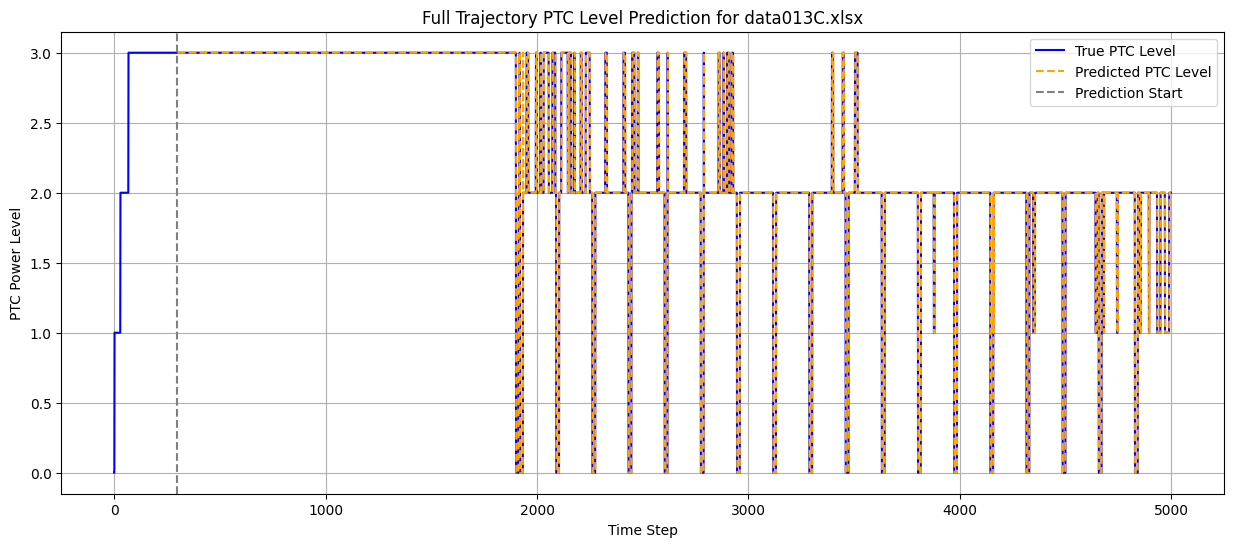

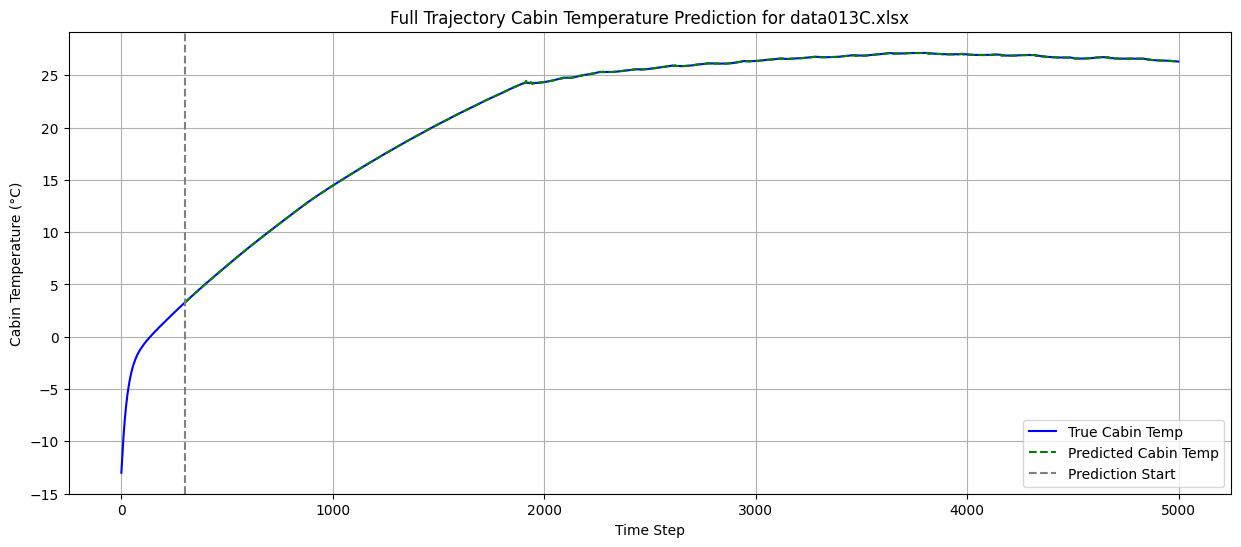

完成文件 data013C.xlsx 的预测和绘图。


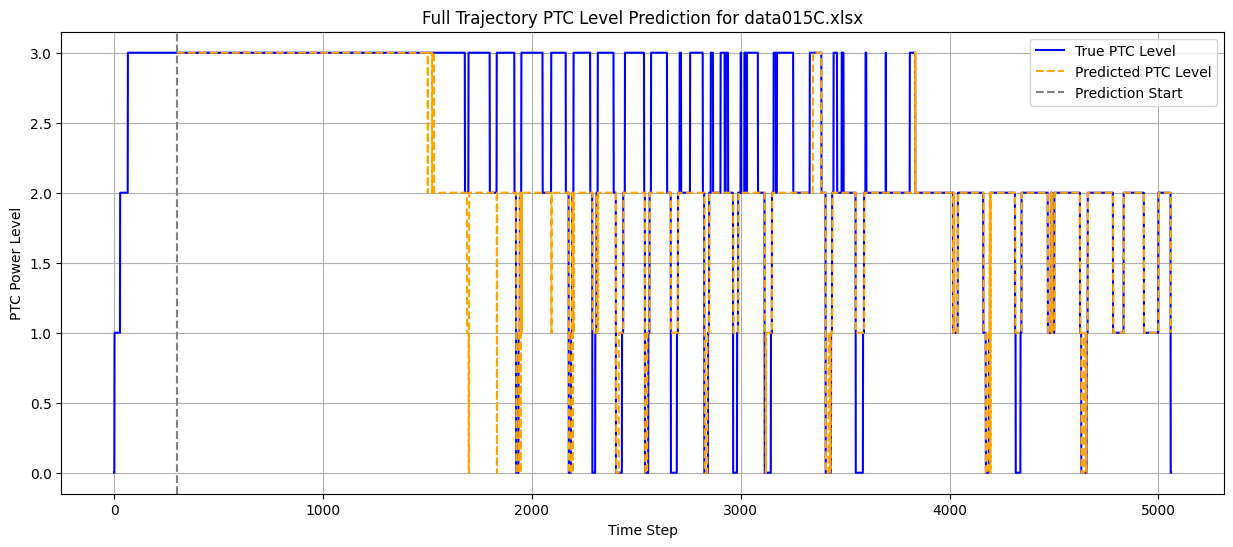

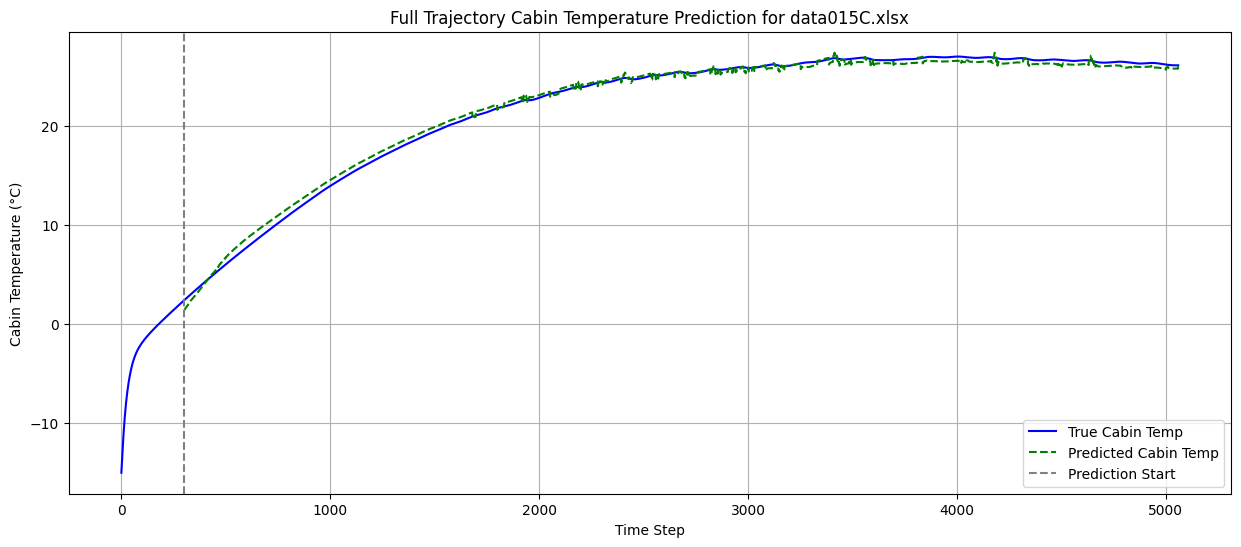

完成文件 data015C.xlsx 的预测和绘图。


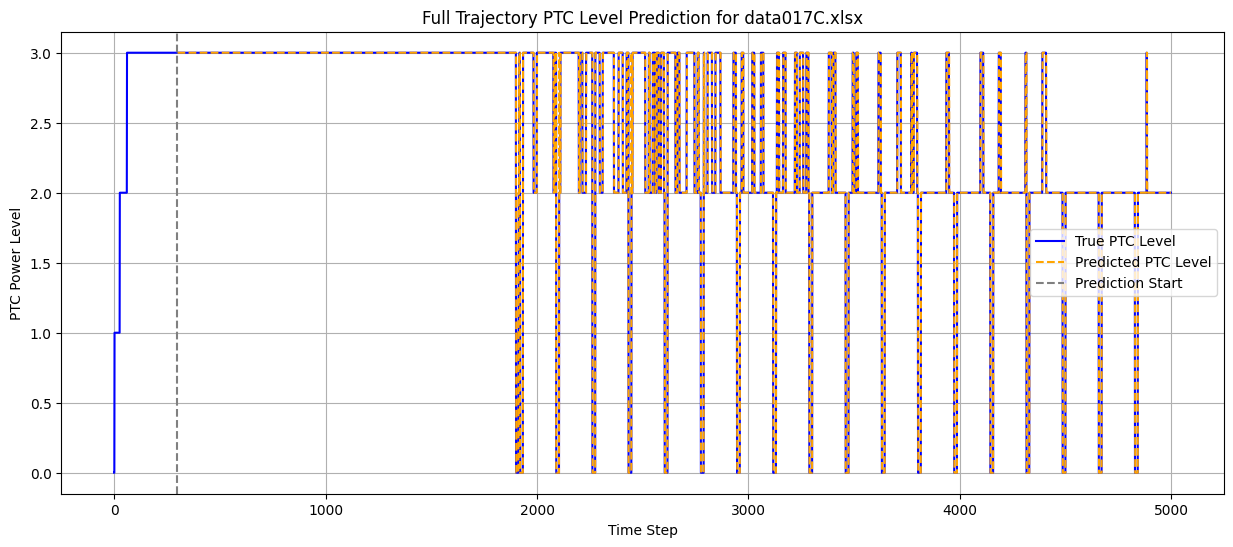

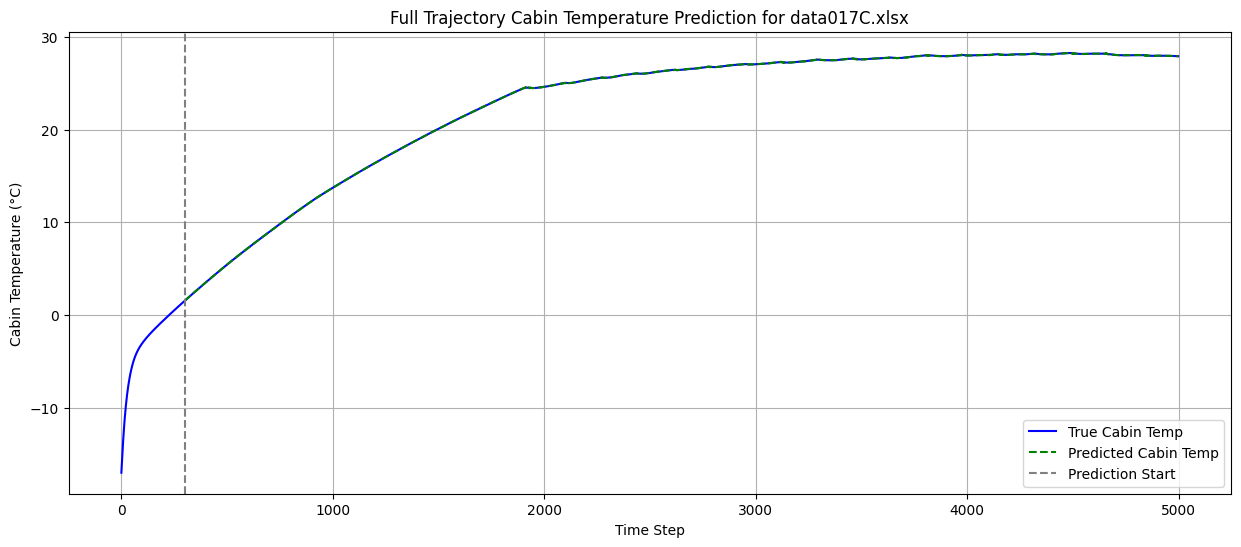

完成文件 data017C.xlsx 的预测和绘图。


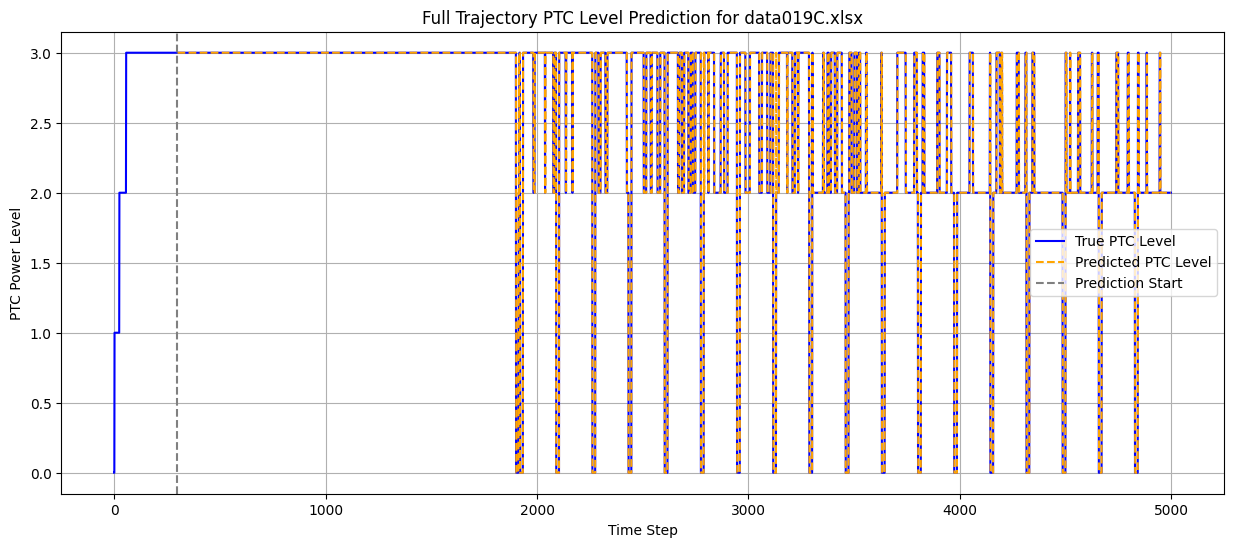

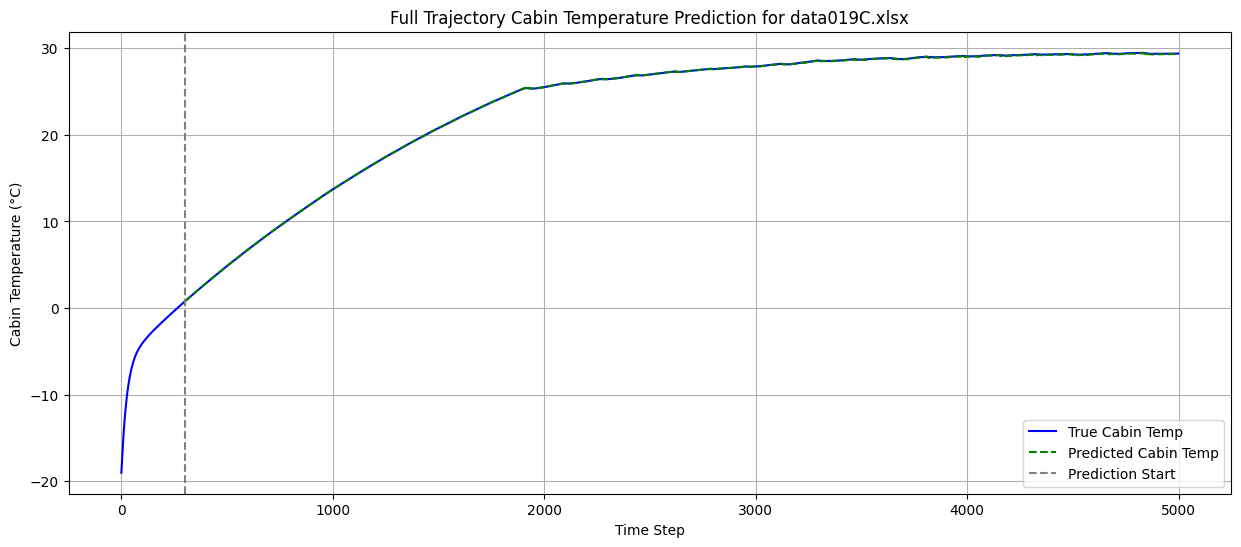

完成文件 data019C.xlsx 的预测和绘图。


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

class MultiTask_PINN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiTask_PINN_Model, self).__init__()

        # Shared encoder (Bi-LSTM + Attention) for both tasks
        self.bi_lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        self.attention_mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

        # Task 1: PTC Power Level Prediction (Classification Head)
        self.power_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

        # Task 2: Cabin Temperature Prediction (Regression Head)
        self.temp_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.bi_lstm(x)
        attn_scores = self.attention_mlp(lstm_out)
        attn_weights = F.softmax(attn_scores, dim=1)
        context_vector = torch.sum(lstm_out * attn_weights, dim=1)

        power_logits = self.power_head(lstm_out)
        predicted_temp = self.temp_head(lstm_out)

        return power_logits, predicted_temp

# --- 加载模型和归一化统计量 ---
model_save_path = '../model/best_model.pt'
if not os.path.exists(model_save_path):
    raise FileNotFoundError(f"未找到模型文件: {model_save_path}")

checkpoint = torch.load(model_save_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiTask_PINN_Model(
    input_size=12,
    hidden_size=256,
    num_classes=4
)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 获取归一化统计量
norm_stats = checkpoint['normalization_stats']
mean_ambient_temp = norm_stats['mean_ambient']
std_ambient_temp = norm_stats['std_ambient']
mean_cabin_temp = norm_stats['mean_cabin']
std_cabin_temp = norm_stats['std_cabin']

# 获取测试数据
excel_data_directory = r"../data/test"
excel_file_list = [f for f in os.listdir(excel_data_directory) if f.startswith('data') and f.endswith('.xlsx')]
excel_file_list.sort()

if not excel_file_list:
    print("警告: 指定文件夹中没有找到任何以 'data' 开头的 .xlsx 文件。")
else:
    print(f"--- 找到 {len(excel_file_list)} 个文件，开始逐一进行全程预测 ---")

    for file_name in excel_file_list:
        file_path = os.path.join(excel_data_directory, file_name)
        
        try:
            df = pd.read_excel(file_path)
            ambient_temp = df['ACambientTemp'].values
            cabin_temp = df['AC CabinTemp'].values
            cabin_PTC_power_level = df['AC PTC Cabin Power_level'].values.astype(int)
            current_len = min(len(ambient_temp), len(cabin_temp), len(cabin_PTC_power_level))

            ambient_temp = ambient_temp[:current_len]
            cabin_temp = cabin_temp[:current_len]
            cabin_PTC_power_level = cabin_PTC_power_level[:current_len]
            
            onehot_cabin_PTC_power_level = np.zeros(shape=(current_len, 4))
            for i, level in enumerate(cabin_PTC_power_level):
                if 0 <= level < 4:
                    onehot_cabin_PTC_power_level[i, int(level)] = 1
                
            test_data = np.concatenate([
                ambient_temp[:, np.newaxis],
                cabin_temp[:, np.newaxis],
                onehot_cabin_PTC_power_level
            ], axis=-1)

            sequence_length = 300
            if test_data.shape[0] < sequence_length + 1:
                print(f"跳过文件 {file_name}: 数据长度 ({test_data.shape[0]}) 不足，至少需要 {sequence_length + 1} 个时间步。")
                continue

            # 全程预测
            all_power_predictions = []
            all_temp_predictions = []
            all_true_levels = np.argmax(test_data[:, 2:], axis=-1)
            all_true_temp = test_data[:, 1]

            input_window_data = test_data[:sequence_length].copy().astype(np.float32)
            
            for i in range(sequence_length, len(test_data)):
                # 1. 归一化和特征工程
                data_normalized = input_window_data.copy()
                data_normalized[:, 0] = (data_normalized[:, 0] - mean_ambient_temp) / std_ambient_temp
                data_normalized[:, 1] = (data_normalized[:, 1] - mean_cabin_temp) / std_cabin_temp

                diff_ambient_temp = np.diff(data_normalized[:, 0], axis=0)
                diff_cabin_temp = np.diff(data_normalized[:, 1], axis=0)
                diff_features_padded = np.pad(np.stack([diff_ambient_temp, diff_cabin_temp], axis=-1),
                                              ((1, 0), (0, 0)), mode='constant')

                df_window = pd.DataFrame(data_normalized[:, 2:6], columns=['l0', 'l1', 'l2', 'l3'])
                window_stats = df_window.rolling(window=5).mean().values
                window_stats[np.isnan(window_stats)] = 0

                input_seq = np.concatenate([data_normalized, diff_features_padded, window_stats], axis=-1)
                
                # 2. 模型预测
                input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    power_logits, predicted_temp = model(input_tensor)
                
                # 3. 提取最后一个时间步的预测结果
                pred_power_level = torch.argmax(power_logits[0, -1, :]).item()
                pred_cabin_temp = predicted_temp[0, -1, :].item()
                
                all_power_predictions.append(pred_power_level)
                all_temp_predictions.append(pred_cabin_temp)
                
                # 4. 更新滑动窗口 (使用原始数据进行下一轮预测)
                next_step_data = test_data[i]
                input_window_data = np.vstack([input_window_data[1:], next_step_data])

            # 为了绘图对齐，对预测列表进行填充
            all_power_predictions = [np.nan] * sequence_length + all_power_predictions
            all_temp_predictions = [np.nan] * sequence_length + all_temp_predictions

            # --- 可视化 PTC 功率等级预测 ---
            plt.figure(figsize=(15, 6))
            plt.plot(all_true_levels, label='True PTC Level', linestyle='-', color='blue')
            plt.plot(all_power_predictions, label='Predicted PTC Level', linestyle='--', color='orange')
            plt.axvline(x=sequence_length - 1, color='gray', linestyle='--', label='Prediction Start')
            plt.title(f'Full Trajectory PTC Level Prediction for {file_name}')
            plt.xlabel('Time Step')
            plt.ylabel('PTC Power Level')
            plt.legend()
            plt.grid(True)
            plt.show()

            # --- 可视化 座舱温度预测 ---
            plt.figure(figsize=(15, 6))
            plt.plot(all_true_temp, label='True Cabin Temp', linestyle='-', color='blue')
            plt.plot(all_temp_predictions, label='Predicted Cabin Temp', linestyle='--', color='green')
            plt.axvline(x=sequence_length - 1, color='gray', linestyle='--', label='Prediction Start')
            plt.title(f'Full Trajectory Cabin Temperature Prediction for {file_name}')
            plt.xlabel('Time Step')
            plt.ylabel('Cabin Temperature (°C)')
            plt.legend()
            plt.grid(True)
            plt.show()

            print(f"完成文件 {file_name} 的预测和绘图。")

        except Exception as e:
            print(f"处理文件 {file_name} 时发生错误: {e}")
